# Carregamento da Base

In [1]:
pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets

# Imports

In [4]:
import numpy as np
import pandas as pd
import time


# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Reamostragem (classes desbalanceadas)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Validação e busca de hiperparâmetros
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
)

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score,
    classification_report,
    confusion_matrix,
    make_scorer,
)

# Otimizadores
from skopt import BayesSearchCV
from skopt.space import Real as SKOReal, Integer as SKOInteger, Categorical as SKOCategorical
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous as GAContinuous, Integer as GAInteger, Categorical as GACategorical
from scipy import sparse
from scipy.stats import randint, uniform

# Utilidades
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

/home/alef/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pré-Processamento

## Juntar as features e o target

In [4]:
data = pd.concat([X, y], axis=1)
data.columns = list(X.columns) + ['target']

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute1   1000 non-null   object
 1   Attribute2   1000 non-null   int64 
 2   Attribute3   1000 non-null   object
 3   Attribute4   1000 non-null   object
 4   Attribute5   1000 non-null   int64 
 5   Attribute6   1000 non-null   object
 6   Attribute7   1000 non-null   object
 7   Attribute8   1000 non-null   int64 
 8   Attribute9   1000 non-null   object
 9   Attribute10  1000 non-null   object
 10  Attribute11  1000 non-null   int64 
 11  Attribute12  1000 non-null   object
 12  Attribute13  1000 non-null   int64 
 13  Attribute14  1000 non-null   object
 14  Attribute15  1000 non-null   object
 15  Attribute16  1000 non-null   int64 
 16  Attribute17  1000 non-null   object
 17  Attribute18  1000 non-null   int64 
 18  Attribute19  1000 non-null   object
 19  Attribute20  1000 non-null  

## Remoção de Outliers

In [6]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'target']

# IQR capping  
def iqr_cap(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)

# Aplicar capping aos numéricos
for col in numeric_cols:
    data[col] = iqr_cap(data[col])

data[numeric_cols].describe()


,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,20.307000,3051.101000,2.973000,2.845000,35.453500,1.404000,1.0
std,10.615151,2187.140403,1.118715,1.103718,11.106324,0.565335,0.0
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.0
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.0
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.0
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.0
max,42.000000,7882.375000,4.000000,4.000000,64.500000,3.500000,1.0


## Separação Entre Features e Target

In [7]:
X = data.drop('target', axis=1)
y = data['target']

## Separar Features Numericas e Categóricas

In [8]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

## Pipeline de Features

In [9]:
# numéricas: imputar valores ausentes com a mediana e escalar
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categóricas: imputar valores ausentes com o valor mais frequente e aplicar One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

## Processador

In [10]:
# Criar um pré-processador usando ColumnTransformer para aplicar transformações diferentes a diferentes colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Manter outras colunas não especificadas, se houver
)

### Aplicando as Features

In [11]:
X_processed = preprocessor.fit_transform(X)

## Convertendo Rótulo

In [12]:
# Original usa 1 = Good, 2 = Bad. Converter 2 para 0 para ter classes 0 e 1.
y_processed = y.values.ravel()
y_processed = np.where(y_processed == 2, 0, y_processed) # 1 (Good credit), 0 (Bad credit)

## Split Treino e Teste

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.2, random_state=RANDOM_STATE, stratify=y_processed
)

## Dados Sinteticos (SMOTE)

In [14]:
smote = SMOTE(random_state=RANDOM_STATE)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Cenários de Classificação

## Função para Garatir Densidade

In [15]:
# para algoritmos que exigem matriz densa
def to_dense(X):
    return X.toarray() if sparse.issparse(X) else X

In [16]:
X_train_resampled = X_resampled  # resultado do SMOTE
X_test_original = X_test         # teste sem oversampling

X_train_resampled_dense = to_dense(X_train_resampled)
X_test_dense = to_dense(X_test_original)

## PCA

In [17]:
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_resampled_dense)
X_test_pca = pca.transform(X_test_dense)

## Divisão de Cenarios

In [18]:
# Dicionário de cenários de classificação
classification_scenarios = {
    'normal': (X_train_resampled_dense, X_test_dense),
    'pca_3': (X_train_pca, X_test_pca)
}
print({name: train.shape for name, (train, _) in classification_scenarios.items()})

{'normal': (1120, 61), 'pca_3': (1120, 3)}


# Espaços de Hiperparâmetros (Grid, Random, Bayes, Genética)

## K-fold Cross Validation

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Estimadores base

In [20]:
# Estimadores base (modelos)
base_estimators = {
    'rf': RandomForestClassifier(random_state=RANDOM_STATE),
    'knn': KNeighborsClassifier(),
    'svm': SVC(probability=True, random_state=RANDOM_STATE),
    'mlp': MLPClassifier(max_iter=400, solver='adam', early_stopping=True, random_state=RANDOM_STATE)
}

## Grid (compacto)

In [21]:
grid_params = {
    'rf': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    },
    'knn': {
        'n_neighbors': [5, 11, 17],
        'weights': ['uniform', 'distance']
    },
    'svm': {
        'C': [0.5, 1, 5],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'mlp': {
        'hidden_layer_sizes': [(50,), (100,), (150,)],
        'activation': ['relu', 'tanh'],
        'alpha': [1e-5, 1e-4, 1e-3]
    }
}

## Random distributions

In [22]:
random_params = {
    'rf': {
        'n_estimators': randint(50, 300),
        'max_depth': [None] + list(range(5, 16, 5)),
        'min_samples_split': randint(2, 10)
    },
    'knn': {
        'n_neighbors': randint(3, 25),
        'weights': ['uniform', 'distance'],
        'p': randint(1, 3)
    },
    'svm': {
        'C': uniform(0.1, 10),
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    },
    'mlp': {
        'hidden_layer_sizes': [(50,), (100,), (150,)],
        'activation': ['relu', 'tanh', 'logistic'],
        'alpha': uniform(1e-6, 1e-2)
    }
}

## Bayes search spaces

In [23]:
bayes_params = {
    'rf': {
        'n_estimators': SKOInteger(50, 300),
        'max_depth': SKOCategorical([None, 5, 10, 15]),
        'min_samples_split': SKOInteger(2, 10)
    },
    'knn': {
        'n_neighbors': SKOInteger(3, 25),
        'weights': SKOCategorical(['uniform', 'distance']),
        'p': SKOInteger(1, 2)
    },
    'svm': {
        'C': SKOReal(0.1, 10.0, prior='log-uniform'),
        'gamma': SKOCategorical(['scale', 'auto']),
        'kernel': SKOCategorical(['rbf', 'linear'])
    },
    'mlp': {
        'activation': SKOCategorical(['relu', 'tanh', 'logistic']),
        'alpha': SKOReal(1e-6, 1e-2, prior='log-uniform')
    }
}

## GA search spaces

In [24]:
ga_params = {
    'rf': {
        'n_estimators': GAInteger(50, 300),
        'max_depth': GACategorical([None, 5, 10, 15]),
        'min_samples_split': GAInteger(2, 10)
    },
    'knn': {
        'n_neighbors': GAInteger(3, 25),
        'weights': GACategorical(['uniform', 'distance']),
        'p': GAInteger(1, 2)
    },
    'svm': {
        'C': GAContinuous(0.1, 10.0),
        'gamma': GACategorical(['scale', 'auto']),
        'kernel': GACategorical(['rbf', 'linear'])
    },
    'mlp': {
        'activation': GACategorical(['relu', 'tanh', 'logistic']),
        'alpha': GAContinuous(1e-6, 1e-2)
    }
}

# Otimização e Métricas

## Métricas de Avaliação

In [25]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'kappa': make_scorer(cohen_kappa_score)
}

## Função fit search

In [26]:
def fit_search(search_obj, X, y):
    """
    Para medir o tempo de execução do fit em 
    buscas de hiperparâmetros
    """
    start = time.time()
    search_obj.fit(X, y)
    return search_obj, time.time() - start

## Função de Criação do Otimizador

In [27]:
def build_search(algorithm_key: str, optimizer_type: str):
    """
    Retorna um objeto de busca de hiperparâmetros configurado para o algoritmo
    e o otimizador especificados.
    """
    estimator = base_estimators[algorithm_key]
    scoring_metric = 'f1'

    if optimizer_type == 'grid':
        return GridSearchCV(
            estimator=estimator,
            param_grid=grid_params[algorithm_key],
            cv=cv,
            scoring=scoring_metric,
            n_jobs=-1,
            refit=True
        )

    if optimizer_type == 'random':
        return RandomizedSearchCV(
            estimator=estimator,
            param_distributions=random_params[algorithm_key],
            n_iter=15,
            cv=cv,
            scoring=scoring_metric,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            refit=True
        )

    if optimizer_type == 'bayes':
        return BayesSearchCV(
            estimator=estimator,
            search_spaces=bayes_params[algorithm_key],
            n_iter=20,
            cv=cv,
            scoring=scoring_metric,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            refit=True
        )

    if optimizer_type == 'genetic':
        return GASearchCV(
            estimator=estimator,
            param_grid=ga_params[algorithm_key],
            cv=cv,
            scoring=scoring_metric,
            population_size=12,
            generations=8,
            tournament_size=3,
            n_jobs=-1,
            verbose=False
        )

    raise ValueError(f"Tipo de busca inválido: {optimizer_type}")

## Função para Avaliar um Estimador

In [28]:
def evaluate_best(best_estimator, X_train, y_train, X_test, y_test):
    """
    Avalia um estimador: calcula médias/desvios das métricas via CV e métricas no conjunto de teste.
    Retorna um dicionário com chaves:
      - {metric}_cv_mean, {metric}_cv_std  (accuracy, precision, recall, f1, roc_auc, kappa)
      - {metric}_test (accuracy_test, precision_test, recall_test, f1_test, roc_auc_test, kappa_test)
    """
    metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'kappa']

    def _cv_summary(est, X, y):
        cv_results = cross_validate(est, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
        mean_dict = {f'{m}_cv_mean': np.mean(cv_results[f'test_{m}']) for m in metrics_list}
        std_dict = {f'{m}_cv_std': np.std(cv_results[f'test_{m}']) for m in metrics_list}
        return {**mean_dict, **std_dict}

    def _get_proba(est, X):
        # retorna probabilidade positiva (ou aproximação)
        if hasattr(est, 'predict_proba'):
            return est.predict_proba(X)[:, 1]
        if hasattr(est, 'decision_function'):
            dec = est.decision_function(X).reshape(-1, 1)
            return MinMaxScaler().fit_transform(dec).ravel()
        # fallback: usar predições (binário 0/1) como "probabilidade" aproximada
        return est.predict(X)

    def _test_metrics(est, X, y_true):
        y_pred = est.predict(X)
        y_proba = _get_proba(est, X)
        # roc_auc pode falhar se houver apenas uma classe nas predições/probabilidades
        try:
            roc_auc = roc_auc_score(y_true, y_proba)
        except Exception:
            roc_auc = np.nan
        return {
            'accuracy_test': accuracy_score(y_true, y_pred),
            'precision_test': precision_score(y_true, y_pred),
            'recall_test': recall_score(y_true, y_pred),
            'f1_test': f1_score(y_true, y_pred),
            'roc_auc_test': roc_auc,
            'kappa_test': cohen_kappa_score(y_true, y_pred)
        }

    cv_summary = _cv_summary(best_estimator, X_train, y_train)
    test_summary = _test_metrics(best_estimator, X_test, y_test)
    return {**cv_summary, **test_summary}

# Execução dos Experimentos

In [29]:
experiment_records = []
best_result_per_scenario = {}

optimizer_list = ['grid', 'random', 'bayes', 'genetic']

## Loop Principal 

In [30]:
def _execute_search(algorithm_key, optimizer_type, X_train_scenario, y_train_scenario, X_test_scenario, y_test_scenario):
    """
    Constrói, ajusta e avalia uma busca. Retorna (record, None) em sucesso ou (None, error_message) em falha.
    """
    try:
        search_obj = build_search(algorithm_key, optimizer_type)
        fitted_search, elapsed_seconds = fit_search(search_obj, X_train_scenario, y_train_scenario)
        best_estimator = fitted_search.best_estimator_
        metrics = evaluate_best(best_estimator, X_train_scenario, y_train_scenario, X_test_scenario, y_test_scenario)

        record = {
            'scenario': None,  # preenchido pelo chamador
            'algorithm': algorithm_key,
            'optimizer': optimizer_type,
            'time_sec': elapsed_seconds,
            'best_params': fitted_search.best_params_,
        }
        record.update(metrics)
        return record, None
    except Exception as e:
        return None, str(e)


for scenario_name, (X_train_scenario, X_test_scenario) in classification_scenarios.items():
    print(f"\n=== Cenário: {scenario_name} ===")
    y_train_scenario = y_resampled
    y_test_scenario = y_test

    scenario_start = time.time()
    scenario_records = []
    failures = []

    for algorithm_key in base_estimators.keys():
        for optimizer_type in optimizer_list:
            print(f" - {algorithm_key.upper()} via {optimizer_type} ...", end=' ')
            record, error = _execute_search(
                algorithm_key,
                optimizer_type,
                X_train_scenario,
                y_train_scenario,
                X_test_scenario,
                y_test_scenario
            )
            if record is not None:
                record['scenario'] = scenario_name
                experiment_records.append(record)
                scenario_records.append(record)
                print("OK")
            else:
                failures.append({
                    'scenario': scenario_name,
                    'algorithm': algorithm_key,
                    'optimizer': optimizer_type,
                    'error': error
                })
                print(f"Falhou ({error})")

    scenario_elapsed = time.time() - scenario_start

    # Selecionar melhor por F1 em teste neste cenário
    if scenario_records:
        scenario_df = pd.DataFrame(scenario_records)
        top_row = scenario_df.sort_values('f1_test', ascending=False).iloc[0]

        best_result_per_scenario[scenario_name] = {
            'algorithm': top_row['algorithm'],
            'optimizer': top_row['optimizer'],
            'f1_test': top_row['f1_test'],
            'roc_auc_test': top_row['roc_auc_test'],
            'best_params': top_row['best_params'],
            'n_runs': len(scenario_records),
            'n_failures': len(failures),
            'failures': failures
        }

        print(f"-> Melhor: {top_row['algorithm'].upper()} + {top_row['optimizer']} | f1_test={top_row['f1_test']:.4f} | tempo_cenário={scenario_elapsed:.1f}s")
    else:
        best_result_per_scenario[scenario_name] = {
            'algorithm': None,
            'optimizer': None,
            'f1_test': None,
            'roc_auc_test': None,
            'best_params': None,
            'n_runs': 0,
            'n_failures': len(failures),
            'failures': failures
        }
        print(f"-> Nenhum experimento bem-sucedido neste cenário (tempo_cenário={scenario_elapsed:.1f}s).")



=== Cenário: normal ===
 - RF via grid ... OK
 - RF via random ... OK
 - RF via random ... OK
 - RF via bayes ... OK
 - RF via bayes ... OK
 - RF via genetic ... OK
 - RF via genetic ... OK
 - KNN via grid ... OK
 - KNN via random ... OK
 - KNN via grid ... OK
 - KNN via random ... OK
 - KNN via bayes ... OK
 - KNN via bayes ... OK
 - KNN via genetic ... OK
 - KNN via genetic ... OK
 - SVM via grid ... OK
 - SVM via grid ... OK
 - SVM via random ... OK
 - SVM via random ... OK
 - SVM via bayes ... OK
 - SVM via bayes ... OK
 - SVM via genetic ... OK
 - SVM via genetic ... OK
 - MLP via grid ... OK
 - MLP via grid ... OK
 - MLP via random ... OK
 - MLP via random ... OK
 - MLP via bayes ... OK
 - MLP via bayes ... OK
 - MLP via genetic ... OK
 - MLP via genetic ... OK
-> Melhor: RF + random | f1_test=0.8235 | tempo_cenário=287.6s

=== Cenário: pca_3 ===
 - RF via grid ... OK
-> Melhor: RF + random | f1_test=0.8235 | tempo_cenário=287.6s

=== Cenário: pca_3 ===
 - RF via grid ... OK
 - 

## Consolidar resultados

In [31]:
experiment_results = pd.DataFrame(experiment_records)
print("\nResumo (top 10 por F1 em teste):")
if not experiment_results.empty:
    display(experiment_results.sort_values(['scenario', 'f1_test'], ascending=[True, False]).head(10))

print('\nMelhores por cenário:')
for scen, info in best_result_per_scenario.items():
    print(scen, '=>', info)

experiment_results.to_csv('resultados_experimentos.csv', index=False)


Resumo (top 10 por F1 em teste):


,scenario,algorithm,optimizer,time_sec,best_params,accuracy_cv_mean,precision_cv_mean,recall_cv_mean,f1_cv_mean,roc_auc_cv_mean,...,recall_cv_std,f1_cv_std,roc_auc_cv_std,kappa_cv_std,accuracy_test,precision_test,recall_test,f1_test,roc_auc_test,kappa_test
1,normal,rf,random,10.931897,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",0.849107,0.834394,0.871429,0.852226,0.925446,...,0.031237,0.019523,0.009301,0.037201,0.745,0.798658,0.850000,0.823529,0.794286,0.365672
0,normal,rf,grid,6.254917,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.846429,0.837010,0.860714,0.848255,0.922816,...,0.036857,0.018545,0.009784,0.032242,0.740,0.823529,0.800000,0.811594,0.787262,0.392523
2,normal,rf,bayes,25.663683,"{'max_depth': 15, 'min_samples_split': 3, 'n_e...",0.851786,0.834242,0.878571,0.855536,0.927583,...,0.026245,0.013489,0.008891,0.025505,0.725,0.793103,0.821429,0.807018,0.785119,0.329268
3,normal,rf,genetic,90.193166,"{'n_estimators': 276, 'max_depth': None, 'min_...",0.857143,0.838973,0.883929,0.860705,0.928045,...,0.025877,0.014522,0.008134,0.026486,0.720,0.783784,0.828571,0.805556,0.783571,0.306931
10,normal,svm,bayes,15.727480,"{'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}",0.858929,0.896727,0.812500,0.852024,0.941486,...,0.024614,0.014120,0.014539,0.026845,0.715,0.790210,0.807143,0.798587,0.722857,0.311594
11,normal,svm,genetic,58.652644,"{'C': 9.317198553940596, 'gamma': 'scale', 'ke...",0.858929,0.895253,0.814286,0.852308,0.940976,...,0.024223,0.012778,0.014631,0.024354,0.715,0.790210,0.807143,0.798587,0.725119,0.311594
14,normal,mlp,bayes,10.633513,"{'activation': 'relu', 'alpha': 0.001867755735...",0.748214,0.766185,0.717857,0.738326,0.820408,...,0.094929,0.067031,0.038358,0.118934,0.720,0.833333,0.750000,0.789474,0.774762,0.375000
8,normal,svm,grid,5.139695,"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.856250,0.886675,0.817857,0.850428,0.935029,...,0.028571,0.019669,0.013822,0.036770,0.700,0.789855,0.778571,0.784173,0.741310,0.292453
9,normal,svm,random,7.649476,"{'C': 4.419450186421157, 'gamma': 'scale', 'ke...",0.855357,0.881994,0.821429,0.850153,0.933530,...,0.029342,0.018125,0.013851,0.033216,0.695,0.780142,0.785714,0.782918,0.744405,0.270335
15,normal,mlp,genetic,28.702915,"{'activation': 'relu', 'alpha': 0.005083389385...",0.749107,0.766541,0.719643,0.739608,0.820233,...,0.093576,0.066939,0.038342,0.119443,0.715,0.848739,0.721429,0.779923,0.777738,0.383117



Melhores por cenário:
normal => {'algorithm': 'rf', 'optimizer': 'random', 'f1_test': np.float64(0.8235294117647058), 'roc_auc_test': np.float64(0.7942857142857143), 'best_params': {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 237}, 'n_runs': 16, 'n_failures': 0, 'failures': []}
pca_3 => {'algorithm': 'rf', 'optimizer': 'grid', 'f1_test': np.float64(0.7730496453900709), 'roc_auc_test': np.float64(0.6672619047619048), 'best_params': {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}, 'n_runs': 16, 'n_failures': 0, 'failures': []}


# Análise dos Resultados

## Gráfico de Comparação

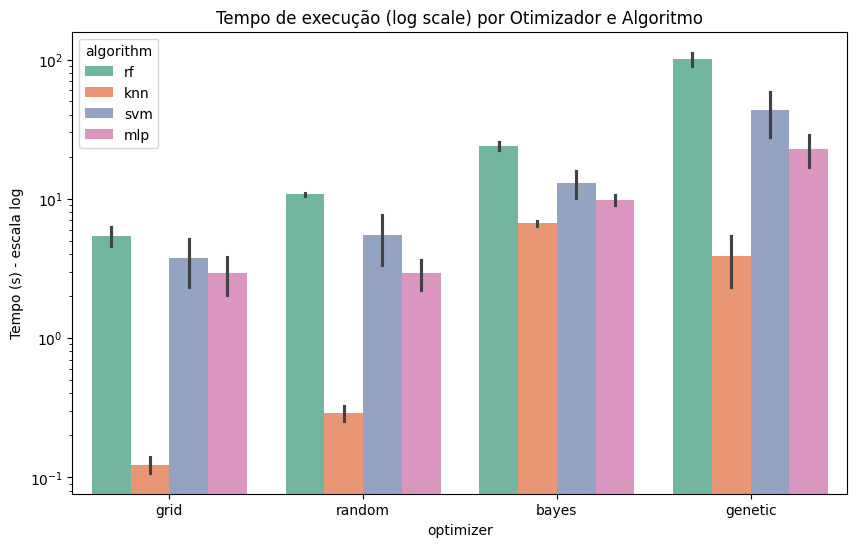

In [ ]:
df = experiment_results.copy()

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="optimizer", y="time_sec", hue="algorithm")
plt.yscale("log")
plt.title("Tempo de execução (log scale) por Otimizador e Algoritmo")
plt.ylabel("Tempo (s) - escala log")
plt.show()


## Tabelas Resumo

In [ ]:
%pip install ace_tools

In [ ]:
df = pd.read_csv('resultados_experimentos.csv')

# 1. Melhor resultado por algoritmo (baseado em accuracy_test)
best_by_alg = df.loc[df.groupby("algorithm")["accuracy_test"].idxmax()]
best_by_alg_reset = best_by_alg.reset_index(drop=True)

# 2. Média das métricas por otimizador
mean_by_opt = df.groupby("optimizer")[["accuracy_test","precision_test","recall_test","f1_test","roc_auc_test"]].mean().reset_index()

# 3. Média das métricas por algoritmo
mean_by_alg = df.groupby("algorithm")[["accuracy_test","precision_test","recall_test","f1_test","roc_auc_test"]].mean().reset_index()

# 4. Comparação PCA vs Normal (média das métricas)
mean_by_scenario = df.groupby("scenario")[["accuracy_test","precision_test","recall_test","f1_test","roc_auc_test"]].mean().reset_index()

# 5. Tempo médio por algoritmo e otimizador
time_table = df.groupby(["algorithm","optimizer"])["time_sec"].mean().reset_index()

# Tabela: melhores parâmetros por algoritmo (linha do melhor resultado)
best_by_alg = df.loc[df.groupby("algorithm")["accuracy_test"].idxmax()][
    ["algorithm","optimizer","best_params","accuracy_test","precision_test", "recall_test","f1_test","roc_auc_test"]
].reset_index(drop=True)

tools.display_dataframe_to_user("Melhores parâmetros por algoritmo", best_by_alg)
# Display tables
tools.display_dataframe_to_user("Melhor resultado por algoritmo", best_by_alg_reset)
tools.display_dataframe_to_user("Métricas médias por otimizador", mean_by_opt)
tools.display_dataframe_to_user("Métricas médias por algoritmo", mean_by_alg)
tools.display_dataframe_to_user("Métricas médias por cenário", mean_by_scenario)
tools.display_dataframe_to_user("Tempo médio por algoritmo e otimizador", time_table)



=== Melhores parâmetros por algoritmo ===


,algorithm,optimizer,best_params,accuracy_test,precision_test,recall_test,f1_test,roc_auc_test
0,knn,random,"{'n_neighbors': 18, 'p': 1, 'weights': 'distan...",0.700,0.822581,0.728571,0.772727,0.755357
1,mlp,bayes,"OrderedDict([('activation', 'relu'), ('alpha',...",0.720,0.833333,0.750000,0.789474,0.774762
2,rf,random,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",0.745,0.798658,0.850000,0.823529,0.794286
3,svm,bayes,"OrderedDict([('C', 10.0), ('gamma', 'scale'), ...",0.715,0.790210,0.807143,0.798587,0.722857



=== Melhor resultado por algoritmo ===


,scenario,algorithm,optimizer,time_sec,best_params,accuracy_cv_mean,precision_cv_mean,recall_cv_mean,f1_cv_mean,roc_auc_cv_mean,...,recall_cv_std,f1_cv_std,roc_auc_cv_std,kappa_cv_std,accuracy_test,precision_test,recall_test,f1_test,roc_auc_test,kappa_test
0,normal,knn,random,0.323235,"{'n_neighbors': 18, 'p': 1, 'weights': 'distan...",0.807143,0.845252,0.755357,0.795814,0.898103,...,0.056073,0.028219,0.028702,0.044963,0.700,0.822581,0.728571,0.772727,0.755357,0.336283
1,normal,mlp,bayes,10.633513,"OrderedDict([('activation', 'relu'), ('alpha',...",0.748214,0.766185,0.717857,0.738326,0.820408,...,0.094929,0.067031,0.038358,0.118934,0.720,0.833333,0.750000,0.789474,0.774762,0.375000
2,normal,rf,random,10.931897,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",0.849107,0.834394,0.871429,0.852226,0.925446,...,0.031237,0.019523,0.009301,0.037201,0.745,0.798658,0.850000,0.823529,0.794286,0.365672
3,normal,svm,bayes,15.727480,"OrderedDict([('C', 10.0), ('gamma', 'scale'), ...",0.858929,0.896727,0.812500,0.852024,0.941486,...,0.024614,0.014120,0.014539,0.026845,0.715,0.790210,0.807143,0.798587,0.722857,0.311594



=== Métricas médias por otimizador ===


,optimizer,accuracy_test,precision_test,recall_test,f1_test,roc_auc_test
0,bayes,0.674375,0.784617,0.736607,0.758810,0.684472
1,genetic,0.671250,0.780426,0.739286,0.757683,0.685417
2,grid,0.657500,0.794722,0.689286,0.734793,0.694747
3,random,0.668125,0.790500,0.716964,0.748992,0.697917



=== Métricas médias por algoritmo ===


,algorithm,accuracy_test,precision_test,recall_test,f1_test,roc_auc_test
0,knn,0.631250,0.770953,0.674107,0.717575,0.650126
1,mlp,0.656250,0.815415,0.656250,0.725673,0.700298
2,rf,0.705625,0.785482,0.797321,0.791130,0.725759
3,svm,0.678125,0.778414,0.754464,0.765899,0.686369



=== Métricas médias por cenário ===


,scenario,accuracy_test,precision_test,recall_test,f1_test,roc_auc_test
0,normal,0.705313,0.807140,0.764286,0.783031,0.749044
1,pca_3,0.630313,0.767992,0.676786,0.717108,0.632232



=== Tempo médio por algoritmo e otimizador ===


,algorithm,optimizer,time_sec
0,knn,bayes,6.654042
1,knn,genetic,3.871482
2,knn,grid,0.123109
3,knn,random,0.288450
4,mlp,bayes,9.803872
5,mlp,genetic,22.763524
6,mlp,grid,2.916495
7,mlp,random,2.926440
8,rf,bayes,23.976904
9,rf,genetic,101.031667
